In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne
import pickle 


from gait_modulation.utils.file_reader import MatFileReader
from gait_modulation.utils.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.utils.feature_extractor import FeatureExtractor

from gait_modulation.utils.utils import load_config

# Loading the data

In [3]:
config = load_config('gait_modulation/configs/data_preprocessing.yaml')

In [4]:
# Handle multiple patients with nested directories.
root_directory = config['data']['root_directory']
mat_reader = MatFileReader(root_directory, max_workers=1)  # adjust the number of workers for parallelism later.

# Read all data from nested folders of multiple patients and sessions
all_data = mat_reader.read_data()
n_sessions = len(all_data)

print(f"Number of sessions: {n_sessions}")

Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_4_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/mast

In [5]:
# Access specific sessions for a patient
session = all_data[0] # pick any session e.g. first one to load the meta data

# Extract LFP meta data for subject/session
lfp_metadata = DataProcessor.np_to_dict(session['hdr_LFP'])

# Load LFP parameters
lfp_sfreq = lfp_metadata['Fs'].item()
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels'].item()

# Prepare for mne data structure. #TODO: fix nr. of channels
info = mne.create_info(ch_names=lfp_ch_names[0:6], sfreq=lfp_sfreq, ch_types='dbs', verbose=40)

# Define normal walking events and mod_start
event_of_interest = config['events']['event_of_interest']
other_events = config['events']['other_events']

mod_start_event_id = config['events']['mod_start_event_id']
normal_walking_event_id = config['events']['normal_walking_event_id']

# Define the event dictionary
event_dict = {
    event_of_interest: mod_start_event_id,
    other_events: normal_walking_event_id
}

# Segmentation parameters
epoch_tmin = config['segmentation']['epoch_tmin']
epoch_tmax = config['segmentation']['epoch_tmax']
epoch_duration = epoch_tmax - epoch_tmin
epoch_sample_length = int(epoch_duration * lfp_sfreq)
gap_duration = config['segmentation']['gap_duration']
gap_sample_length = int(gap_duration * lfp_sfreq)

In [ ]:
epochs_list = []
events_list = []
all_lfp_data = []

for s in range(n_sessions):
    print(f'Session: {s}')
    session = all_data[s] # Access specific patient/sessions

    # Extract events and lfp data of the subject/session
    lfp_data = session['data_LFP'] * 1e-6  # Convert microvolts to volts
    
    # lfp_raw = mne.io.RawArray(lfp_data, info, verbose=40)
    # lfp_raw.plot(start=0, duration=np.inf, remove_dc=False)
    # plt.show()

    # Handle events
    events_KIN = DataProcessor.np_to_dict(session['events_KIN'])
    events_before_trim, event_dict_before_trim = DataProcessor.create_events_array(events_KIN, lfp_sfreq)

    # Trim the data and adjust the event onsets accordingly
    lfp_data, events_after_trim = DataProcessor.trim_data(lfp_data, events_before_trim, lfp_sfreq)
    lfp_duration = lfp_data.shape[1] / lfp_sfreq
    n_samples = int(lfp_duration * lfp_sfreq)

    all_lfp_data.append(lfp_data)
        
    # Update raw data after trimming
    lfp_raw = mne.io.RawArray(lfp_data, info, verbose=40)
    
    # events_mod_start = events_before_trim[events_before_trim[:, 2] == event_dict_before_trim[event_of_interest]]
    events_mod_start = events_after_trim[events_after_trim[:, 2] == event_dict_before_trim[event_of_interest]]
    events_mod_start[:, 1] = s # mark the session nr  
    # print("--->", np.unique(events_mod_start[:, 1]), np.unique(events_mod_start[:, 2], return_counts=True))

    # Rename Gait Modulation Events
    events_mod_start[:, 2] = mod_start_event_id
        
    # Define normal walking events
    normal_walking_events = DataProcessor.define_normal_walking_events(
        normal_walking_event_id, events_mod_start,
        gap_sample_length, epoch_sample_length, n_samples
    )
    
    events_mod_start[:, 1] = s # mark the session nr
    normal_walking_events[:, 1] = s # mark the session nr

    # ## Remove artifacts from raw LFP data using ICA.
    # ica_n_components = 6 # 6 = n_channels.
    # ica = mne.preprocessing.ICA(n_components=ica_n_components, random_state=97, max_iter=800, verbose=40)
    # print(lfp_raw.ch_names)
    # ica.fit(lfp_raw)
    # raw_data_clean = ica.apply(lfp_raw, verbose=40) # Apply ICA to the raw data

    # Combine events and create epochs
    events, epochs = DataProcessor.create_epochs_with_events(
        lfp_raw,
        events_mod_start,
        normal_walking_events,
        mod_start_event_id,
        normal_walking_event_id,
        epoch_tmin,
        epoch_tmax,
        event_dict
    )
    print(f"Total epochs: {len(epochs)}")
    for cls in event_dict.keys():
        print(f"{cls}: {len(epochs[cls])} epochs", end='; ')
    
    # events[:, 1] = s # No need to mark the session nr for events again!
    epochs.events[:, 1] = s # mark the session nr
    
    my_annot = mne.Annotations(
        onset=(events[:, 0] - epoch_sample_length) / lfp_sfreq,  # in seconds
        # onset=events[:, 0]/lfp_sfreq,  # in seconds
        duration=len(events)*[epoch_duration],  # in seconds, too
        description=events[:, 2],
    )
    lfp_raw.set_annotations(my_annot)
    
    fig = lfp_raw.plot(start=0, duration=np.inf, show=False) # lfp_duration
    fig.suptitle(f'Session {s}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'images/session{s}.png')
    plt.close(fig)
    
    epochs_list.append(epochs)
    events_list.append(events)
    
    print("\n==========================================================")


epochs = mne.concatenate_epochs(epochs_list, verbose=40)
events = np.vstack(events_list)
events = events[np.argsort(events[:, 0])]  # TODO: Sort by onset time

Session: 0
Number of samples removed: 14738
Number of seconds removed: 58.95 seconds
------events_after_trim------ [[ 2828     0     1]
 [15808     0     1]
 [21593     0     1]
 [29083     0     1]
 [38678     0     1]
 [50533     0     1]
 [57388     0     1]
 [63673     0     1]
 [68453     0     1]
 [74408     0     1]
 [ 3522     0     2]
 [16461     0     2]
 [22070     0     2]
 [29642     0     2]
 [39259     0     2]
 [51074     0     2]
 [58005     0     2]
 [64252     0     2]
 [68915     0     2]
 [75056     0     2]
 [ 4375     0     3]
 [17719     0     3]
 [22473     0     3]
 [30347     0     3]
 [40046     0     3]
 [52359     0     3]
 [58545     0     3]
 [64779     0     3]
 [69328     0     3]
 [75717     0     3]
 [ 5632     0     4]
 [11317     0     4]
 [18942     0     4]
 [28514     0     4]
 [40542     0     4]
 [53344     0     4]
 [58067     0     4]
 [64554     0     4]
 [ 6732     0     5]
 [11439     0     5]
 [19694     0     5]
 [28892     0     5]
 [4

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_45091/995412120.py:79: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 5
No trimming needed as the beginning of signal is not flat.
------events_after_trim------ [[ 9977     0     1]
 [11727     0     1]
 [13627     0     1]
 [15317     0     1]
 [17157     0     1]
 [19187     0     1]
 [21112     0     1]
 [22887     0     1]
 [24627     0     1]
 [26387     0     1]
 [28212     0     1]
 [30187     0     1]
 [32077     0     1]
 [33977     0     1]
 [35762     0     1]
 [37642     0     1]
 [39657     0     1]
 [41817     0     1]
 [44407     0     1]
 [10214     0     2]
 [11951     0     2]
 [13866     0     2]
 [15564     0     2]
 [17349     0     2]
 [19393     0     2]
 [21378     0     2]
 [23122     0     2]
 [24819     0     2]
 [26601     0     2]
 [28511     0     2]
 [30456     0     2]
 [32280     0     2]
 [34181     0     2]
 [36028     0     2]
 [37907     0     2]
 [39893     0     2]
 [42050     0     2]
 [44799     0     2]
 [10517     0     3]
 [12276     0     3]
 [14123     0     3]
 [15833     0     3]
 [17815     0    

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_45091/995412120.py:79: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 6
Number of samples removed: 1819
Number of seconds removed: 7.28 seconds
------events_after_trim------ [[ 8122     0     1]
 [10322     0     1]
 [12622     0     1]
 [14517     0     1]
 [16837     0     1]
 [18812     0     1]
 [20812     0     1]
 [22777     0     1]
 [24922     0     1]
 [26962     0     1]
 [29202     0     1]
 [31122     0     1]
 [33147     0     1]
 [35127     0     1]
 [ 8435     0     2]
 [10549     0     2]
 [12874     0     2]
 [14747     0     2]
 [17072     0     2]
 [19075     0     2]
 [21068     0     2]
 [23022     0     2]
 [25151     0     2]
 [27204     0     2]
 [29453     0     2]
 [31366     0     2]
 [33363     0     2]
 [35385     0     2]
 [ 9209     0     3]
 [11004     0     3]
 [13186     0     3]
 [15238     0     3]
 [17400     0     3]
 [19349     0     3]
 [21404     0     3]
 [23391     0     3]
 [25335     0     3]
 [27569     0     3]
 [29780     0     3]
 [31706     0     3]
 [33701     0     3]
 [35781     0     3]
 [10

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_45091/995412120.py:79: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 12
Number of samples removed: 6608
Number of seconds removed: 26.43 seconds
------events_after_trim------ [[ 9351     0     1]
 [15346     0     1]
 [21311     0     1]
 [26031     0     1]
 [31966     0     1]
 [36836     0     1]
 [ 9837     0     2]
 [16057     0     2]
 [21821     0     2]
 [26570     0     2]
 [32417     0     2]
 [37217     0     2]
 [10568     0     3]
 [16589     0     3]
 [22384     0     3]
 [27715     0     3]
 [32971     0     3]
 [37830     0     3]
 [11197     0     4]
 [17317     0     4]
 [23182     0     4]
 [28027     0     4]
 [38557     0     4]
 [11984     0     5]
 [17799     0     5]
 [23712     0     5]
 [28709     0     5]
 [39207     0     5]
 [11962     0     6]
 [18042     0     6]
 [23702     0     6]
 [29034     0     6]
 [39234     0     6]
 [12407     0     7]
 [18334     0     7]
 [24099     0     7]
 [29664     0     7]
 [39584     0     7]
 [13146     0     8]
 [19066     0     8]
 [24301     0     8]
 [29696     0     8]
 [

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_45091/995412120.py:79: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_45091/995412120.py:79: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  lfp_raw.set_annotations(my_annot)



Session: 14
Number of samples removed: 1090
Number of seconds removed: 4.36 seconds
------events_after_trim------ [[ 9117     0     1]
 [13412     0     1]
 [17452     0     1]
 [21787     0     1]
 [26697     0     1]
 [30852     0     1]
 [35842     0     1]
 [39627     0     1]
 [43732     0     1]
 [48687     0     1]
 [ 9635     0     2]
 [13791     0     2]
 [17898     0     2]
 [22158     0     2]
 [27028     0     2]
 [31191     0     2]
 [36207     0     2]
 [40016     0     2]
 [44273     0     2]
 [49064     0     2]
 [10151     0     3]
 [14118     0     3]
 [18414     0     3]
 [23132     0     3]
 [27413     0     3]
 [31935     0     3]
 [36775     0     3]
 [40646     0     3]
 [44953     0     3]
 [49720     0     3]
 [ 5755     0     4]
 [ 9872     0     4]
 [14077     0     4]
 [18377     0     4]
 [27195     0     4]
 [32302     0     4]
 [36110     0     4]
 [40420     0     4]
 [45240     0     4]
 [ 6267     0     5]
 [10162     0     5]
 [14685     0     5]
 [1

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_45091/995412120.py:79: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  lfp_raw.set_annotations(my_annot)


In [7]:
# save all lfp data
with open('processed/all_lfp_data.pkl', 'wb') as f:
    pickle.dump(all_lfp_data, f)
    
# save epoched data
epochs.save(f"processed/lfp_{epoch_tmin}tmin_{gap_duration}gap-epo.fif", overwrite=True)
    

Overwriting existing file.
Overwriting existing file.


In [8]:
# Preprocessing
## Apply band-pass filtering to the raw LFP data.
# l_freq = 1
# h_freq = 50
# epochs.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin', verbose=40)

In [9]:
Visualise.plot_event_occurrence(events=events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/event_classes.png')


Visualise.plot_event_occurrence(events=epochs.events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/epochs.event_classes.png')

Plot saved as images/event_classes.png
Plot saved as images/epochs.event_classes.png


In [10]:
Visualise.plot_event_class_histogram(events=events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/event_class_histogram.png')

Visualise.plot_event_class_histogram(events=epochs.events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/epochs.event_class_histogram.png')

Plot saved as images/event_class_histogram.png
Plot saved as images/epochs.event_class_histogram.png


# Feature Extraction

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.utils.file_reader import MatFileReader
from gait_modulation.utils.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.utils.feature_extractor import FeatureExtractor

In [12]:
epochs = mne.read_epochs('processd/lfp_-3.0tmin_5gap-epo.fif')

FileNotFoundError: File does not exist: "/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/processd/lfp_-3.0tmin_5gap-epo.fif"

In [ ]:
epochs.get_data(copy=False).shape

(893, 6, 751)

In [ ]:
freq_bands = {
    'delta': (0.1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'low_beta': (12, 16),
    'middle_beta': (16, 20),
    'high_beta': (20, 30),
    'gamma': (30, 100),
    'high_gamma': (100, 125)
}

# Both classes features
psd = FeatureExtractor.extract_band_psd(epochs, freq_bands)
print(psd['gamma'].shape) # ((freq band: {n_epochs, n_channels, n_frequencies})


band_power = FeatureExtractor.extract_band_power(epochs, freq_bands)
print(band_power['delta'].shape) # (freq band: {n_epochs x n_channels})

# ------------------------
# mod_start features
psd_mod_start = FeatureExtractor.extract_band_psd(
    epochs['mod_start'], freq_bands)
print(psd_mod_start['gamma'].shape) # ((freq band: {n_epochs, n_channels, n_frequencies})

band_power_mod_start = FeatureExtractor.extract_band_power(
    epochs['mod_start'], freq_bands)
print(band_power_mod_start['delta'].shape) # (freq band: {n_epochs, n_channels})



# ------------------------
# normal_walking features
psd_normal_walking = FeatureExtractor.extract_band_psd(
    epochs['normal_walking'], freq_bands)
print(psd_normal_walking['gamma'].shape) # ((freq band: {n_epochs, n_channels, n_frequencies})

band_power_normal_walking = FeatureExtractor.extract_band_power(
    epochs['normal_walking'], freq_bands)
print(band_power_normal_walking['delta'].shape) # (freq band: {n_epochs, n_channels})



    Using multitaper spectrum estimation with 7 DPSS windows
(893, 6, 210)
    Using multitaper spectrum estimation with 7 DPSS windows
(893, 6)
    Using multitaper spectrum estimation with 7 DPSS windows
(147, 6, 210)
    Using multitaper spectrum estimation with 7 DPSS windows
(147, 6)
    Using multitaper spectrum estimation with 7 DPSS windows
(746, 6, 210)
    Using multitaper spectrum estimation with 7 DPSS windows
(746, 6)


In [ ]:
print("------")
k=0
for band in freq_bands:
    k += np.sum(band_power[band].shape[1]) 
    print(band_power[band].shape)
k

------
(893, 6)
(893, 6)
(893, 6)
(893, 6)
(893, 6)
(893, 6)
(893, 6)
(893, 6)


48

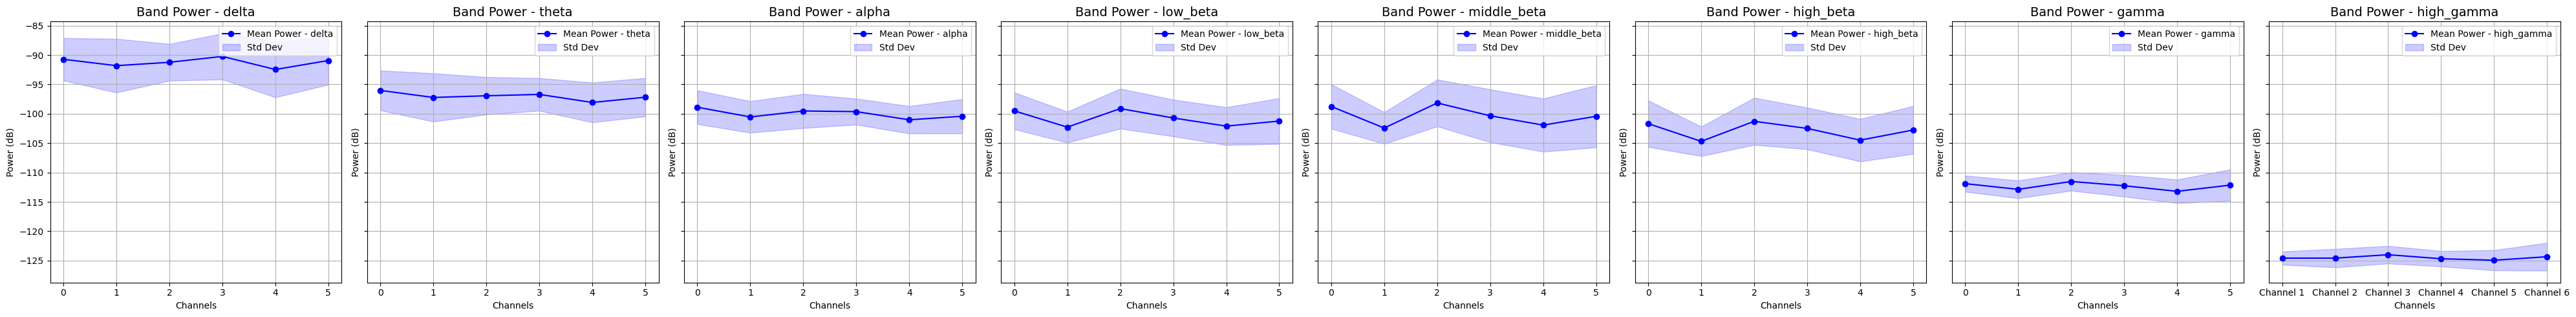

In [ ]:
def visualize_band_power(band_power_features):
    """
    Visualizes the band power features stored in a dictionary.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data) in zip(axes, band_power_features.items()):
        # Calculate mean and standard deviation across epochs for each channel
        mean_power = np.mean(data, axis=0)  # Mean across epochs
        std_power = np.std(data, axis=0)    # Std deviation across epochs

        # Plot mean band power for each channel
        ax.plot(mean_power, label=f'Mean Power - {band}', color='blue', marker='o')
        ax.fill_between(range(data.shape[1]), mean_power - std_power, mean_power + std_power, 
                        color='blue', alpha=0.2, label='Std Dev')
        
        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data.shape[1]), labels=[f'Channel {i+1}' for i in range(data.shape[1])])
    plt.tight_layout()
    plt.show()

# Assuming `band_power_features` is a dictionary containing the band power data.
visualize_band_power(band_power)

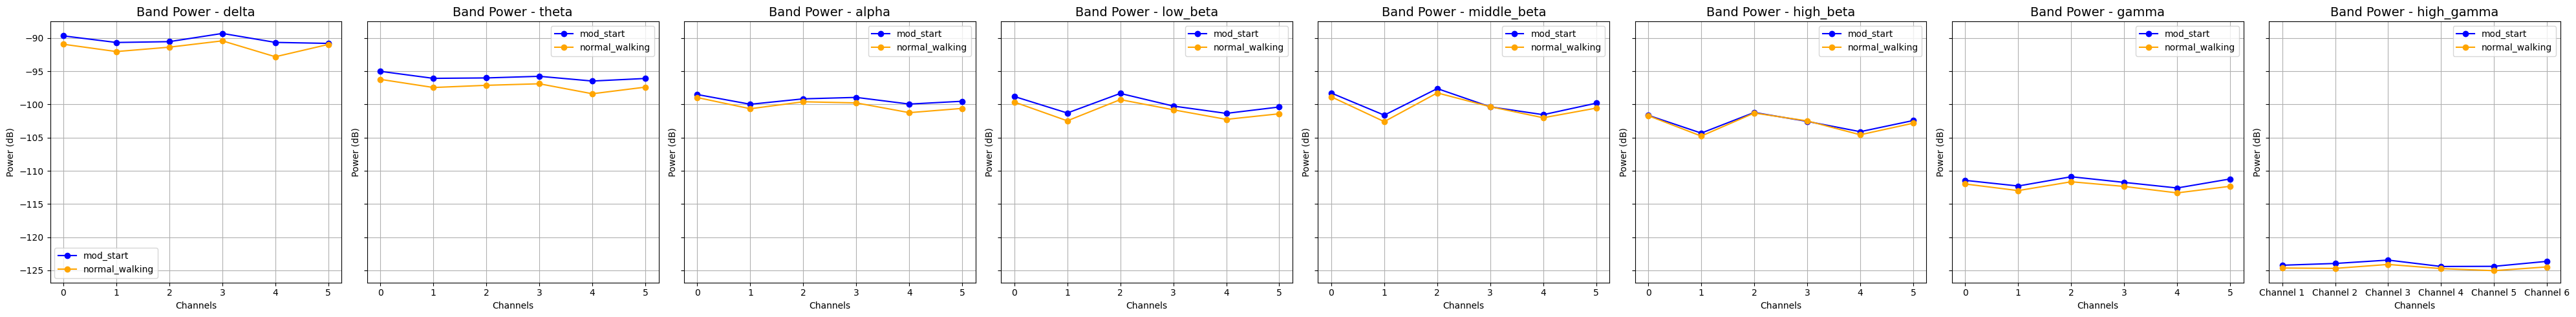

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power(band_power_features_mod, band_power_features_norm):
    """
    Visualizes the band power features for mod_start and normal_walking classes.

    Parameters:
    - band_power_features_mod: dict
        Dictionary for mod_start where keys are frequency bands and values are arrays of shape (epochs, channels).
    - band_power_features_norm: dict
        Dictionary for normal_walking where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features_mod)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data_mod), (_, data_norm) in zip(axes, band_power_features_mod.items(), band_power_features_norm.items()):
        # Calculate mean across epochs for each channel
        mean_power_mod = np.mean(data_mod, axis=0)  # Mean across epochs for mod_start
        mean_power_norm = np.mean(data_norm, axis=0)  # Mean across epochs for normal_walking

        # Plot mean band power for mod_start
        ax.plot(mean_power_mod, label='mod_start', color='blue', marker='o')

        # Plot mean band power for normal_walking
        ax.plot(mean_power_norm, label='normal_walking', color='orange', marker='o')

        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data_mod.shape[1]), labels=[f'Channel {i+1}' for i in range(data_mod.shape[1])])
    plt.tight_layout()
    plt.show()

# Example usage
visualize_band_power(band_power_mod_start, band_power_normal_walking)

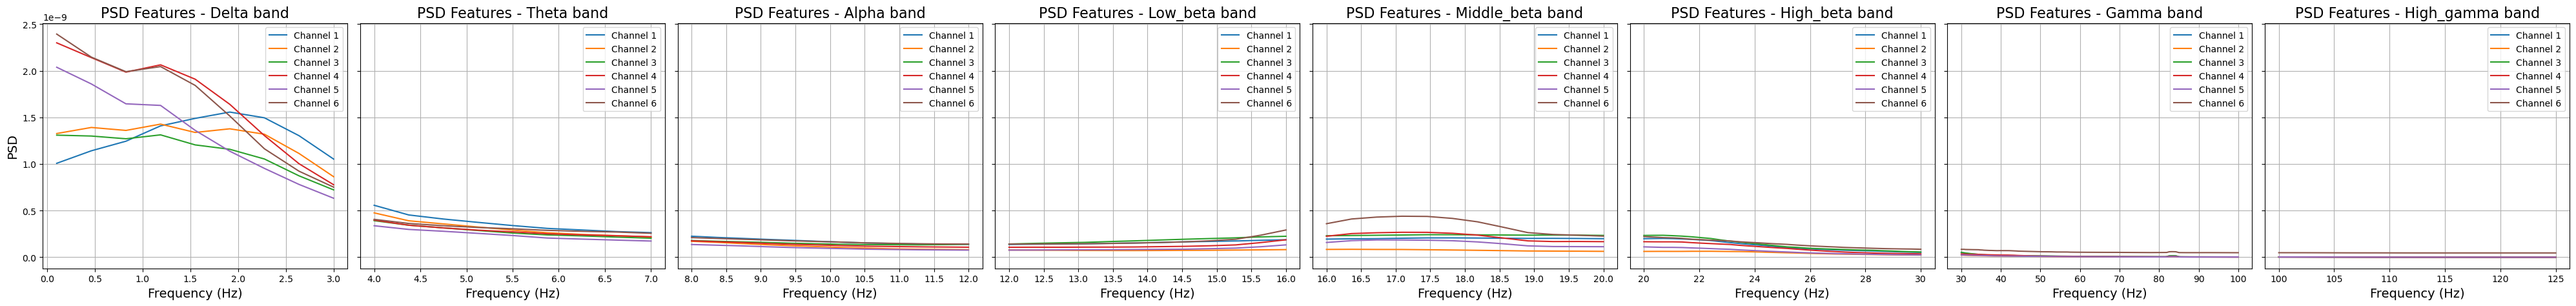

In [ ]:
def visualize_psd(psd_features):
    """
    Visualizes the PSD features for each frequency band.
    
    Parameters:
    - psd_features: Dictionary with frequency bands as keys and values as 
                    arrays of shape (n_epochs, n_channels, n_frequencies).
    """
    num_bands = len(psd_features)
    num_channels = next(iter(psd_features.values())).shape[1]  # Get number of channels

    # Create a figure with subplots for each frequency band
    fig, axes = plt.subplots(1, num_bands, figsize=(5 * num_bands, 5), sharey=True)
    
    # Plot each band
    for i, (band, values) in enumerate(psd_features.items()):
        mean_psd = values.mean(axis=0)  # Average across epochs
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values.shape[2])  # Adjust frequency range per band
        
        for ch in range(num_channels):
            axes[i].plot(freqs, mean_psd[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels
        axes[i].set_title(f'PSD Features - {band.capitalize()} band', fontsize=16)
        axes[i].set_xlabel('Frequency (Hz)', fontsize=14)
        if i == 0:
            axes[i].set_ylabel('PSD', fontsize=14)
        axes[i].legend(loc='upper right')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Example data for testing (use your actual psd_features data here)
visualize_psd(psd)  # Uncomment and run with actual psd_features data

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


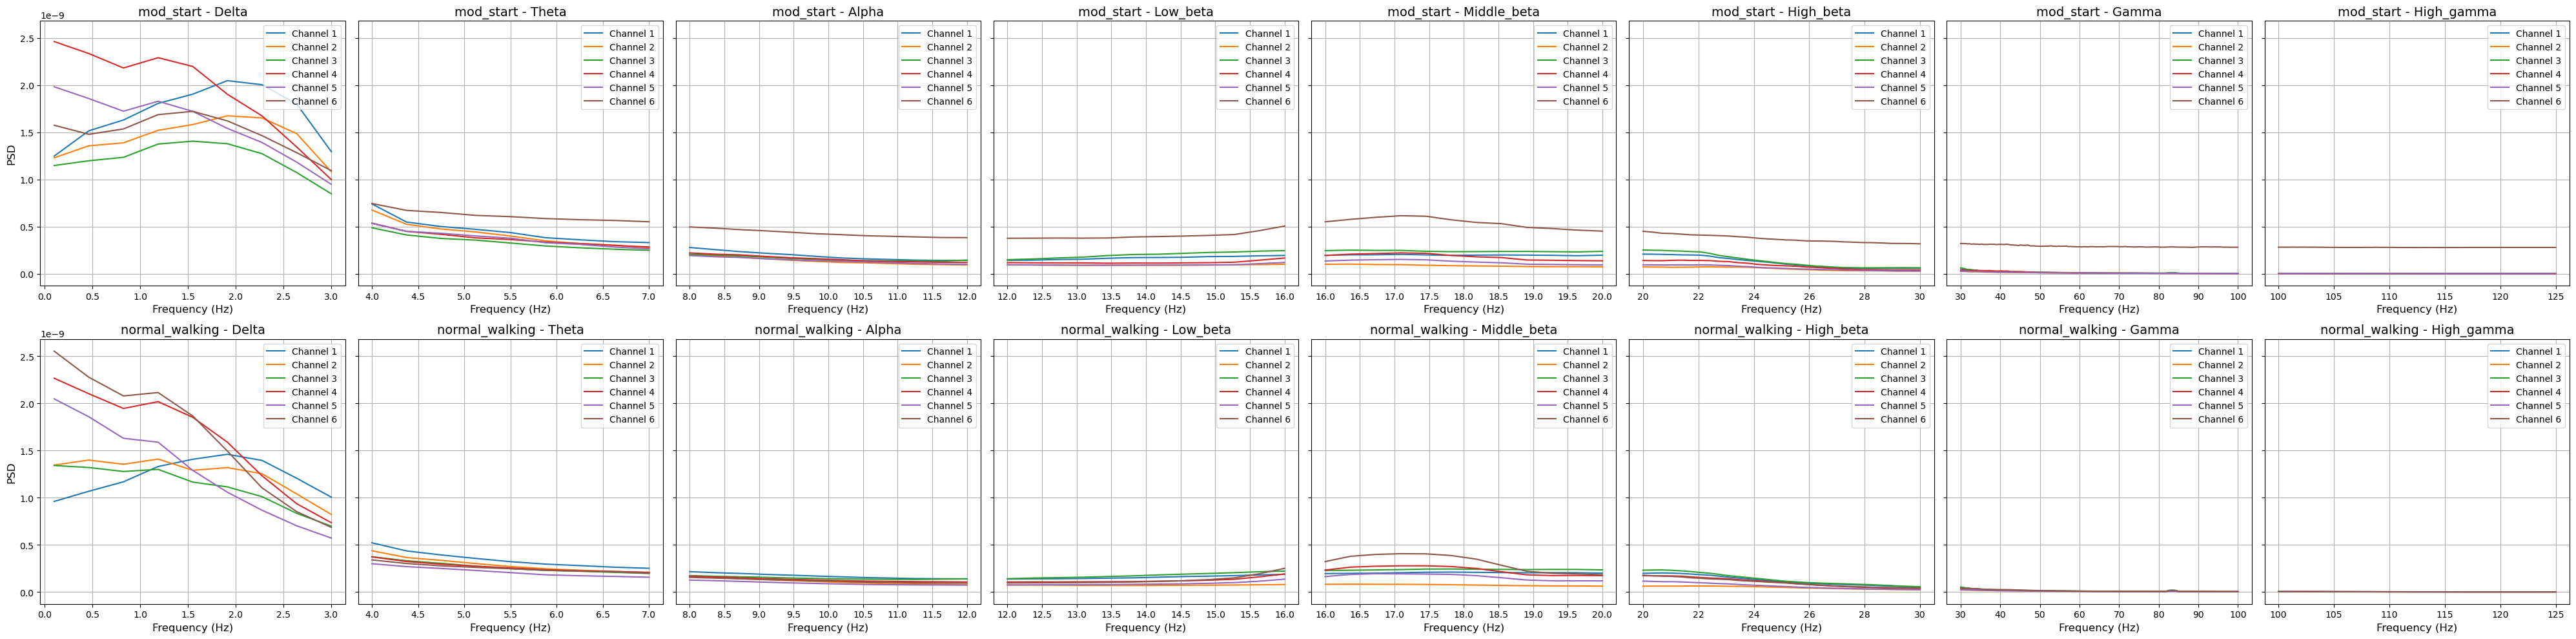

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
    """
    Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking).
    
    Parameters:
    - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
                        values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - freq_bands: Dictionary of frequency bands with their ranges.
    """
    num_bands = len(freq_bands)
    num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
    num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

    fig, axes = plt.subplots(2, num_bands, figsize=(5 * num_bands, 10), sharey=True)

    # Plot PSD for mod_start
    for i, (band, values_mod) in enumerate(psd_features_mod.items()):
        mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs for mod_start
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values_mod.shape[2])  # Set frequency range per band
        
        for ch in range(num_channels_mod):
            axes[0, i].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels for mod_start class
        axes[0, i].set_title(f'mod_start - {band.capitalize()}', fontsize=14)
        axes[0, i].set_xlabel('Frequency (Hz)', fontsize=12)
        if i == 0:
            axes[0, i].set_ylabel('PSD', fontsize=12)
        axes[0, i].grid(True)

    # Plot PSD for normal_walking
    for i, (band, values_norm) in enumerate(psd_features_norm.items()):
        mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs for normal_walking
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values_norm.shape[2])  # Set frequency range per band
        
        for ch in range(num_channels_norm):
            axes[1, i].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels for normal_walking class
        axes[1, i].set_title(f'normal_walking - {band.capitalize()}', fontsize=14)
        axes[1, i].set_xlabel('Frequency (Hz)', fontsize=12)
        if i == 0:
            axes[1, i].set_ylabel('PSD', fontsize=12)
        axes[1, i].grid(True)

    # Add legends and adjust layout
    for ax in axes.flat:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage:
psd_features_mod_start = FeatureExtractor.extract_band_psd(epochs['mod_start'], freq_bands)
psd_features_normal_walking = FeatureExtractor.extract_band_psd(epochs['normal_walking'], freq_bands)

visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)  # Uncomment with actual data

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
#     """
#     Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking),
#     with frequency bands spread along the y-axis.
    
#     Parameters:
#     - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
#                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
#     - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
#                          values as arrays of shape (n_epochs, n_channels, n_frequencies).
#     - freq_bands: Dictionary of frequency bands with their ranges.
#     """
#     num_bands = len(freq_bands)
#     num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
#     num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

#     fig, axes = plt.subplots(num_bands, 2, figsize=(10, 5 * num_bands), sharey=True)

#     # Plot each frequency band on a separate row
#     for i, (band, values_mod) in enumerate(psd_features_mod.items()):
#         # Define frequency range for this band
#         freq_range = freq_bands[band]
#         freqs = np.linspace(freq_range[0], freq_range[1], values_mod.shape[2])

#         # Plot mod_start PSD in the left column
#         mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs
#         for ch in range(num_channels_mod):
#             axes[i, 0].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}')
        
#         # Add title and labels for mod_start
#         axes[i, 0].set_title(f'{band.capitalize()} - mod_start', fontsize=14)
#         axes[i, 0].set_ylabel('PSD', fontsize=12)
#         axes[i, 0].grid(True)
#         if i == num_bands - 1:
#             axes[i, 0].set_xlabel('Frequency (Hz)', fontsize=12)

#         # Plot normal_walking PSD in the right column
#         values_norm = psd_features_norm[band]
#         mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs
#         for ch in range(num_channels_norm):
#             axes[i, 1].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}')
        
#         # Add title and labels for normal_walking
#         axes[i, 1].set_title(f'{band.capitalize()} - normal_walking', fontsize=14)
#         axes[i, 1].grid(True)
#         if i == num_bands - 1:
#             axes[i, 1].set_xlabel('Frequency (Hz)', fontsize=12)

#     # Add legends and adjust layout
#     for ax in axes.flat:
#         ax.legend(loc='upper right')

#     plt.tight_layout()
#     plt.show()

# psd_features_mod_start = FeatureExtractor.extract_band_psd(epochs['mod_start'], freq_bands)
# psd_features_normal_walking = FeatureExtractor.extract_band_psd(epochs['normal_walking'], freq_bands)

# visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)  # Uncomment with actual data

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


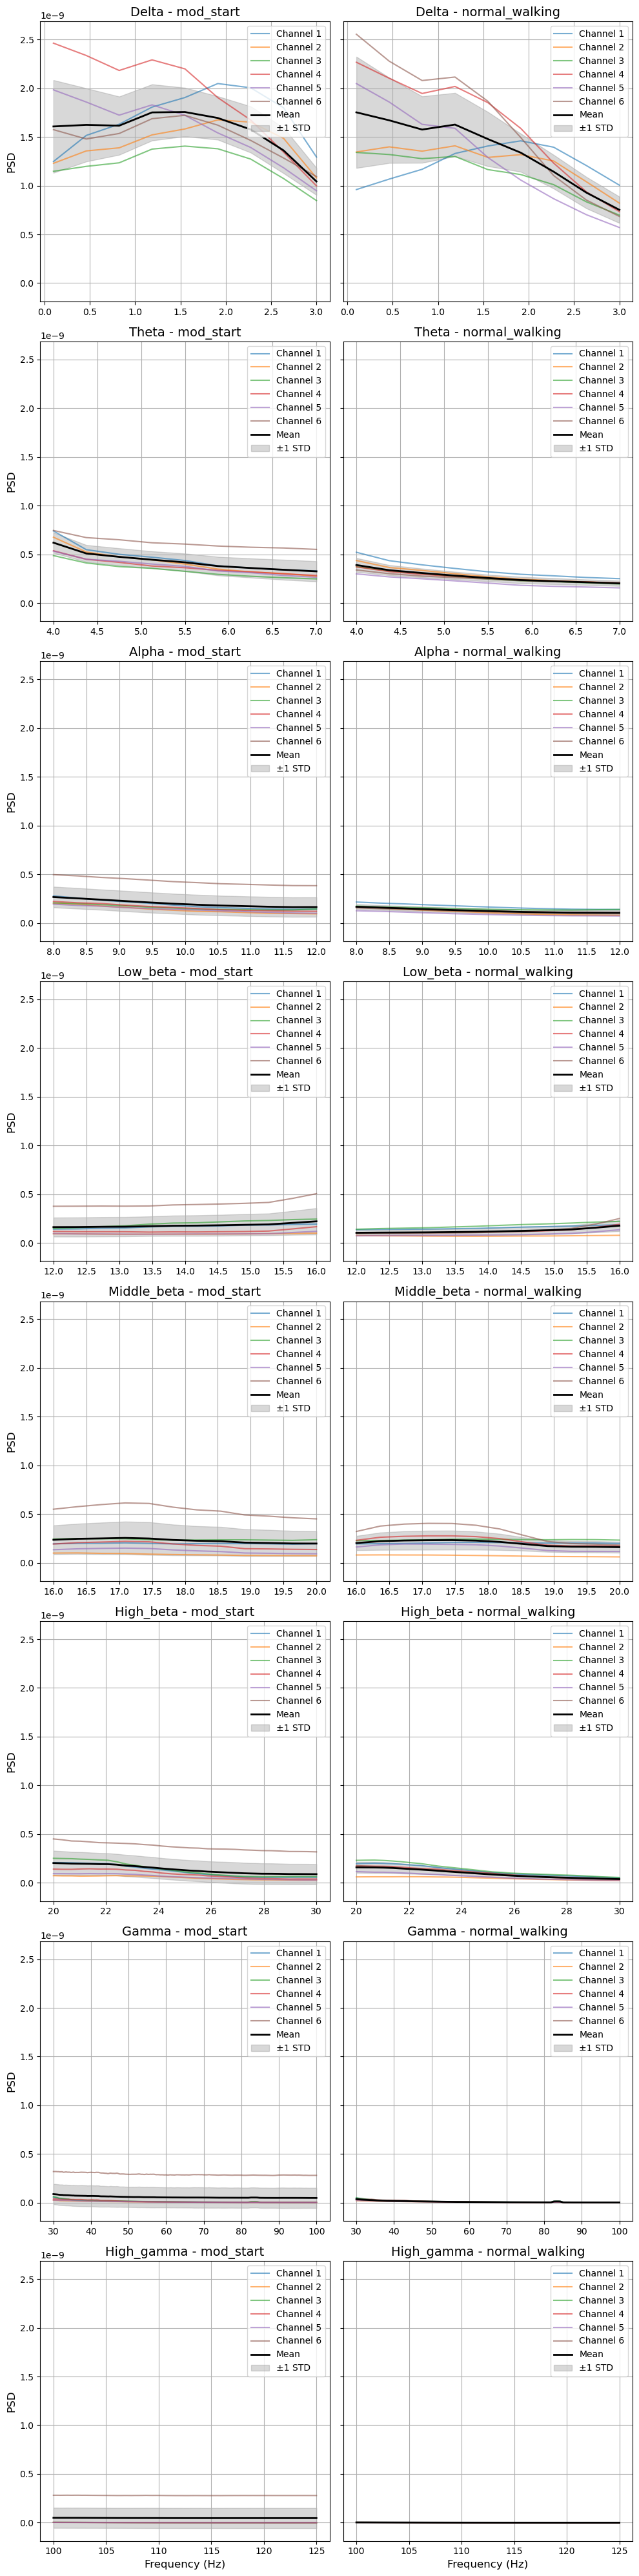

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
    """
    Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking),
    with frequency bands spread along the y-axis. Includes individual channel plots with an overlay of the mean and
    standard deviation across channels.
    
    Parameters:
    - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
                        values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - freq_bands: Dictionary of frequency bands with their ranges.
    """
    num_bands = len(freq_bands)
    num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
    num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

    fig, axes = plt.subplots(num_bands, 2, figsize=(10, 5 * num_bands), sharey=True)

    # Plot each frequency band on a separate row
    for i, (band, values_mod) in enumerate(psd_features_mod.items()):
        # Define frequency range for this band
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values_mod.shape[2])

        # Plot mod_start PSD for each channel
        mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs
        std_psd_mod = values_mod.std(axis=0)  # Standard deviation across epochs
        mean_across_channels_mod = mean_psd_mod.mean(axis=0)  # Mean across channels
        std_across_channels_mod = mean_psd_mod.std(axis=0)  # Std across channels
        
        for ch in range(num_channels_mod):
            axes[i, 0].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}', alpha=0.6)

        # Overlay mean line and standard deviation shading for mod_start
        axes[i, 0].plot(freqs, mean_across_channels_mod, color='black', linewidth=2, label='Mean')
        axes[i, 0].fill_between(freqs, mean_across_channels_mod - std_across_channels_mod,
                                mean_across_channels_mod + std_across_channels_mod, color='gray', alpha=0.3, label='±1 STD')
        
        # Add title and labels for mod_start
        axes[i, 0].set_title(f'{band.capitalize()} - mod_start', fontsize=14)
        axes[i, 0].set_ylabel('PSD', fontsize=12)
        axes[i, 0].grid(True)
        if i == num_bands - 1:
            axes[i, 0].set_xlabel('Frequency (Hz)', fontsize=12)

        # Plot normal_walking PSD for each channel
        values_norm = psd_features_norm[band]
        mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs
        std_psd_norm = values_norm.std(axis=0)  # Standard deviation across epochs
        mean_across_channels_norm = mean_psd_norm.mean(axis=0)  # Mean across channels
        std_across_channels_norm = mean_psd_norm.std(axis=0)  # Std across channels
        
        for ch in range(num_channels_norm):
            axes[i, 1].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}', alpha=0.6)
        
        # Overlay mean line and standard deviation shading for normal_walking
        axes[i, 1].plot(freqs, mean_across_channels_norm, color='black', linewidth=2, label='Mean')
        axes[i, 1].fill_between(freqs, mean_across_channels_norm - std_across_channels_norm,
                                mean_across_channels_norm + std_across_channels_norm, color='gray', alpha=0.3, label='±1 STD')

        # Add title and labels for normal_walking
        axes[i, 1].set_title(f'{band.capitalize()} - normal_walking', fontsize=14)
        axes[i, 1].grid(True)
        if i == num_bands - 1:
            axes[i, 1].set_xlabel('Frequency (Hz)', fontsize=12)

    # Add legends and adjust layout
    for ax in axes.flat:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage:
psd_features_mod_start = FeatureExtractor.extract_band_psd(epochs['mod_start'], freq_bands)
psd_features_normal_walking = FeatureExtractor.extract_band_psd(epochs['normal_walking'], freq_bands)

visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)  # Uncomment with actual data

    Using multitaper spectrum estimation with 7 DPSS windows


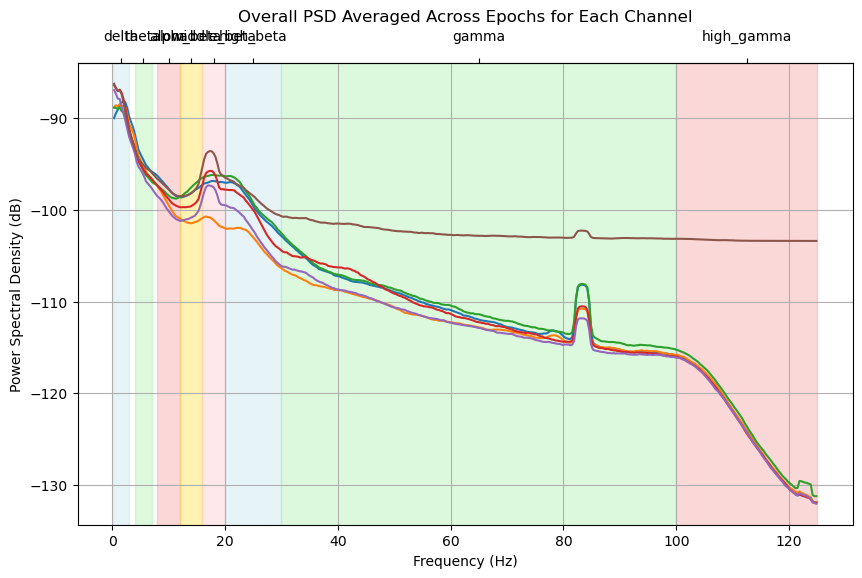

In [ ]:
def plot_overall_psd_with_bands(epochs, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD averaged across epochs for each channel, and marks the frequency bands with different colors and annotations.

    Parameters:
    - epochs: mne.Epochs object containing the LFP data.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """
    # Compute PSD across all epochs and channels, averaging across epochs
    psds, freqs = epochs.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mean = psds.mean(axis=0)  # Average across epochs
    
    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink']

    # Plot overall PSD for each channel
    fig, ax = plt.subplots(figsize=(10, 6))
    for ch in range(psds_mean.shape[0]):  # Iterate over channels
        ax.plot(freqs, 10 * np.log10(psds_mean[ch]), label=f'Channel {ch+1}')

    # Mark frequency bands with distinct colors and create a secondary x-axis for band names
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        ax.axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)

    # Add secondary x-axis to display band names
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])  # Place ticks at the center of each band
    ax_top.set_xticklabels(freq_bands.keys())  # Set the band names as labels
    ax_top.tick_params(axis='x', pad=10)  # Adjust padding of the labels

    # Set labels and title
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (dB)')
    ax.set_title('Overall PSD Averaged Across Epochs for Each Channel')
    
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `epochs` is your MNE Epochs object and `freq_bands` is a dictionary of frequency bands
plot_overall_psd_with_bands(epochs, 
                            freq_bands,
                            fmin=freq_bands['delta'][0],
                            fmax=freq_bands['high_gamma'][1])

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


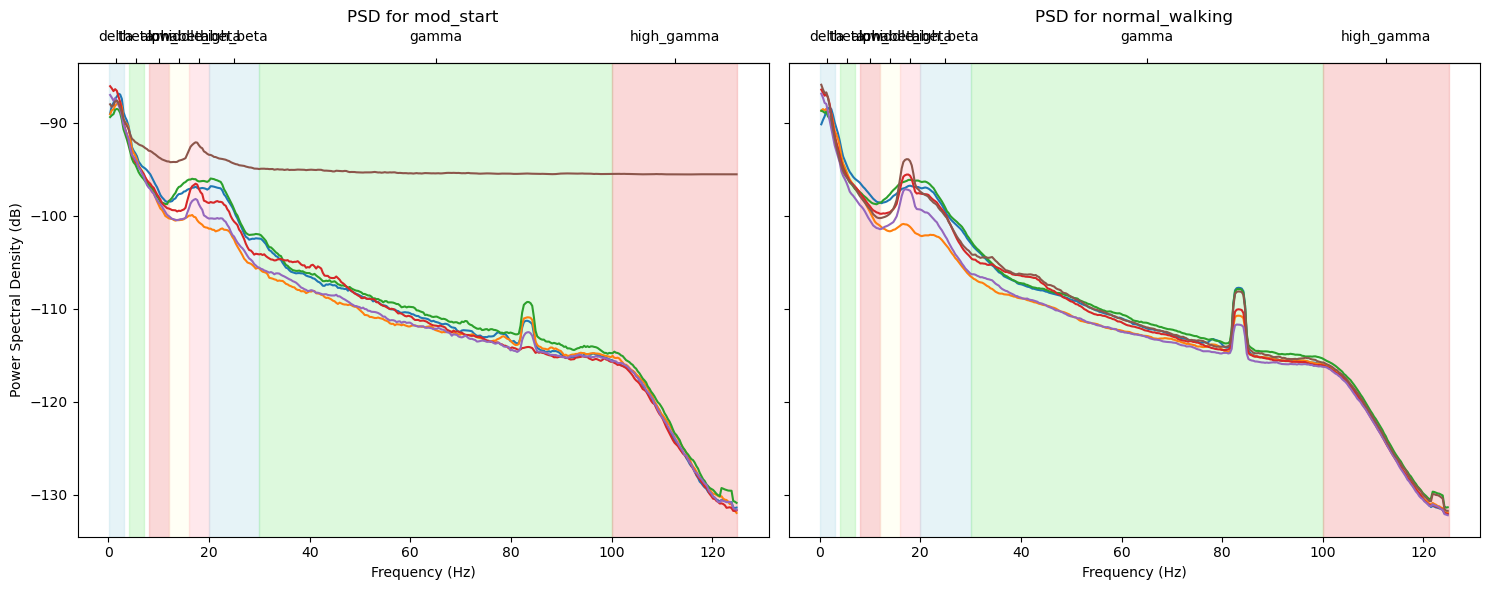

In [ ]:
def plot_overall_psd_with_bands_by_class(epochs_mod, epochs_norm, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD for two classes (mod_start and normal_walking) in separate subplots,
    averaged across epochs for each class and channel. Frequency bands are marked with distinct colors.

    Parameters:
    - epochs_mod: MNE Epochs object for the mod_start class.
    - epochs_norm: MNE Epochs object for the normal_walking class.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """

    # Compute PSD for mod_start class
    psds_mod, freqs_mod = epochs_mod.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mod_mean = psds_mod.mean(axis=0)  # Average across epochs for mod_start

    # Compute PSD for normal_walking class
    psds_norm, freqs_norm = epochs_norm.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_norm_mean = psds_norm.mean(axis=0)  # Average across epochs for normal_walking

    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Plot PSD for mod_start
    for ch in range(psds_mod_mean.shape[0]):
        axes[0].plot(freqs_mod, 10 * np.log10(psds_mod_mean[ch]), label=f'Channel {ch+1}')
    axes[0].set_title('PSD for mod_start')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power Spectral Density (dB)')
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        axes[0].axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)
    ax_top_mod = axes[0].secondary_xaxis('top')
    ax_top_mod.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top_mod.set_xticklabels(freq_bands.keys())
    ax_top_mod.tick_params(axis='x', pad=10)

    # Plot PSD for normal_walking
    for ch in range(psds_norm_mean.shape[0]):
        axes[1].plot(freqs_norm, 10 * np.log10(psds_norm_mean[ch]), label=f'Channel {ch+1}')
    axes[1].set_title('PSD for normal_walking')
    axes[1].set_xlabel('Frequency (Hz)')
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        axes[1].axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)
    ax_top_norm = axes[1].secondary_xaxis('top')
    ax_top_norm.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top_norm.set_xticklabels(freq_bands.keys())
    ax_top_norm.tick_params(axis='x', pad=10)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_overall_psd_with_bands_by_class(epochs['mod_start'],
                                     epochs['normal_walking'], freq_bands,                             fmin=freq_bands['delta'][0],
                                     fmax=freq_bands['high_gamma'][1])

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


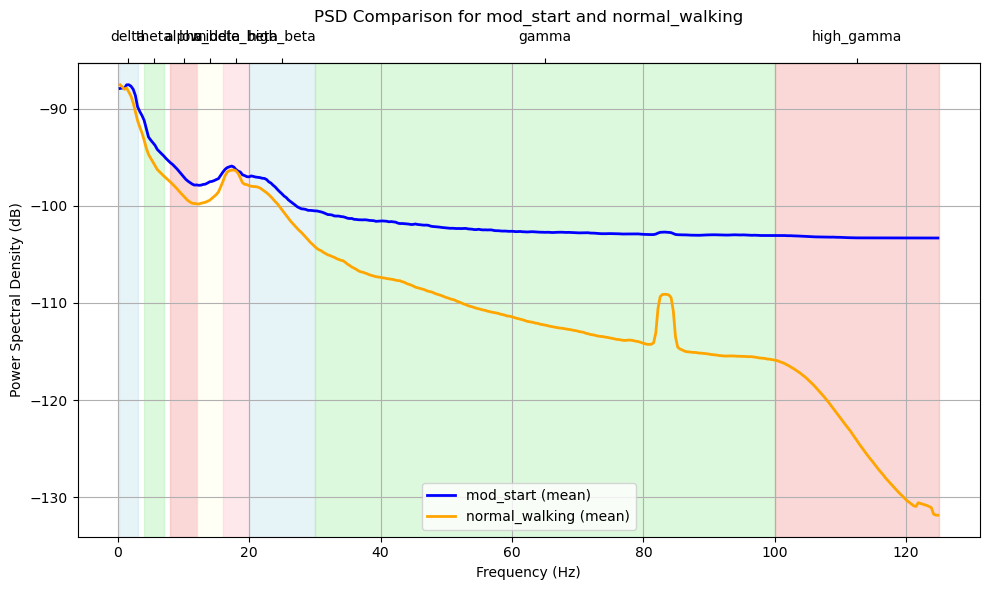

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overall_psd_with_bands_by_class(epochs_mod, epochs_norm, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD for two classes (mod_start and normal_walking) in one plot,
    averaged across epochs and channels. Frequency bands are marked with distinct colors.

    Parameters:
    - epochs_mod: MNE Epochs object for the mod_start class.
    - epochs_norm: MNE Epochs object for the normal_walking class.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """

    # Compute PSD for mod_start class
    psds_mod, freqs_mod = epochs_mod.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mod_mean = psds_mod.mean(axis=(0, 1))  # Average across epochs and channels

    # Compute PSD for normal_walking class
    psds_norm, freqs_norm = epochs_norm.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_norm_mean = psds_norm.mean(axis=(0, 1))  # Average across epochs and channels

    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot the mean PSD for mod_start
    plt.plot(freqs_mod, 10 * np.log10(psds_mod_mean), color='blue', label='mod_start (mean)', linewidth=2)

    # Plot the mean PSD for normal_walking
    plt.plot(freqs_norm, 10 * np.log10(psds_norm_mean), color='orange', label='normal_walking (mean)', linewidth=2)

    # Mark frequency bands with shaded regions
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        plt.axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)

    # Top x-axis for frequency bands
    ax_top = plt.gca().secondary_xaxis('top')
    ax_top.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top.set_xticklabels(freq_bands.keys())
    ax_top.tick_params(axis='x', pad=10)

    # Plot settings
    plt.title('PSD Comparison for mod_start and normal_walking')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_overall_psd_with_bands_by_class(epochs['mod_start'],
                                     epochs['normal_walking'],
                                     freq_bands,
                                     fmin=freq_bands['delta'][0],
                                     fmax=freq_bands['high_gamma'][1])

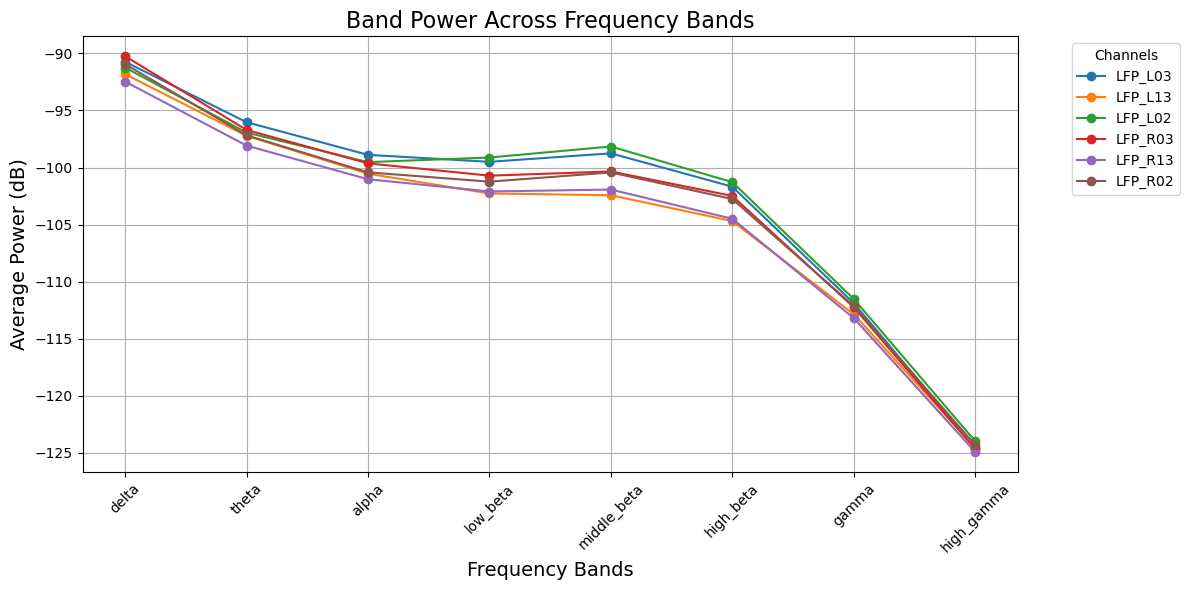

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power_combined(band_power_features, sfreq, ch_names):
    """
    Visualizes the band power features stored in a dictionary in a single plot,
    with each trace representing a channel and the x-axis representing frequency bands.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    - sfreq: float
        Sampling frequency of the data.
    - ch_names: list
        List of channel names corresponding to the data.
    """
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Prepare the x-axis (frequency bands)
    freq_bands = list(band_power_features.keys())
    num_bands = len(freq_bands)

    # Prepare the y-axis data for each channel
    for ch_idx, ch_name in enumerate(ch_names):
        # Extract band power data for this channel
        channel_band_power = [band_power_features[band][:, ch_idx].mean() for band in freq_bands]

        # Plot each channel's band power across frequency bands
        plt.plot(freq_bands, channel_band_power, marker='o', label=ch_name)

    # Add titles and labels
    plt.title('Band Power Across Frequency Bands', fontsize=16)
    plt.xlabel('Frequency Bands', fontsize=14)
    plt.ylabel('Average Power (dB)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title='Channels', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data,
# `sfreq` is your sampling frequency, and `ch_names` is your list of channel names.
visualize_band_power_combined(band_power, lfp_sfreq, lfp_ch_names)

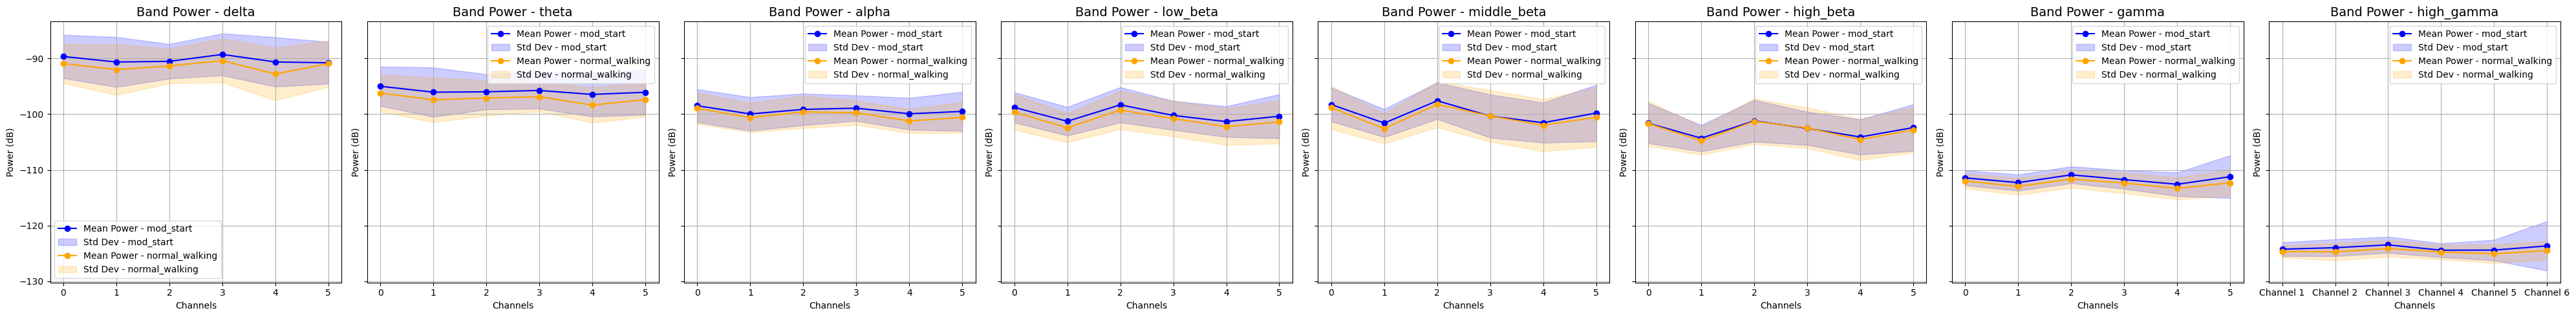

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power(band_power_features_mod, band_power_features_norm):
    """
    Visualizes the band power features for mod_start and normal_walking classes.

    Parameters:
    - band_power_features_mod: dict
        Dictionary for mod_start where keys are frequency bands and values are arrays of shape (epochs, channels).
    - band_power_features_norm: dict
        Dictionary for normal_walking where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features_mod)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data_mod), (_, data_norm) in zip(axes, band_power_features_mod.items(), band_power_features_norm.items()):
        # Calculate mean and standard deviation across epochs for each channel for mod_start
        mean_power_mod = np.mean(data_mod, axis=0)  # Mean across epochs
        std_power_mod = np.std(data_mod, axis=0)    # Std deviation across epochs
        
        # Calculate mean and standard deviation across epochs for each channel for normal_walking
        mean_power_norm = np.mean(data_norm, axis=0)  # Mean across epochs
        std_power_norm = np.std(data_norm, axis=0)    # Std deviation across epochs

        # Plot mean band power for mod_start
        ax.plot(mean_power_mod, label=f'Mean Power - mod_start', color='blue', marker='o')
        ax.fill_between(range(data_mod.shape[1]), mean_power_mod - std_power_mod, mean_power_mod + std_power_mod, 
                        color='blue', alpha=0.2, label='Std Dev - mod_start')

        # Plot mean band power for normal_walking
        ax.plot(mean_power_norm, label=f'Mean Power - normal_walking', color='orange', marker='o')
        ax.fill_between(range(data_norm.shape[1]), mean_power_norm - std_power_norm, mean_power_norm + std_power_norm, 
                        color='orange', alpha=0.2, label='Std Dev - normal_walking')

        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data_mod.shape[1]), labels=[f'Channel {i+1}' for i in range(data_mod.shape[1])])
    plt.tight_layout()
    plt.show()

# Example usage
visualize_band_power(band_power_mod_start, band_power_normal_walking)

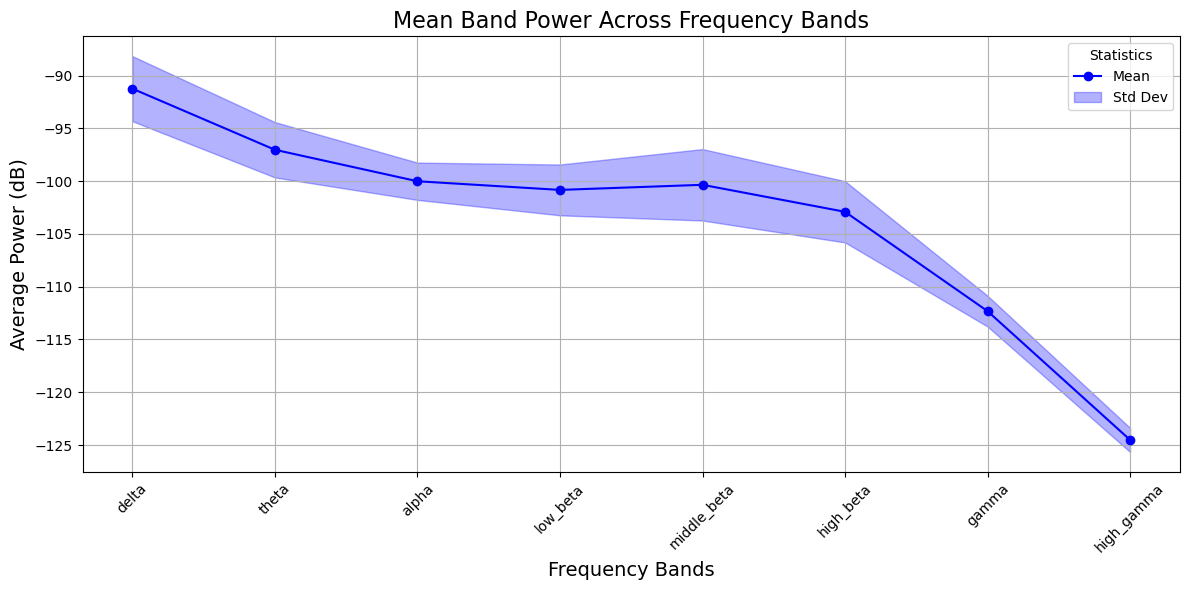

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power_mean_std(band_power_features):
    """
    Visualizes the mean and standard deviation of band power features across channels
    in a single plot, with each trace representing the mean and std across channels.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Prepare the x-axis (frequency bands)
    freq_bands = list(band_power_features.keys())

    # Prepare the y-axis data for mean and std across channels
    mean_band_power = []
    std_band_power = []

    for band in freq_bands:
        # Compute the mean and standard deviation across channels for the current frequency band
        mean_power = band_power_features[band].mean(axis=1)  # Mean across channels
        std_power = band_power_features[band].std(axis=1)    # Std across channels
        
        mean_band_power.append(mean_power)  # Append the mean values
        std_band_power.append(std_power)      # Append the std values

    mean_band_power = np.array(mean_band_power)
    std_band_power = np.array(std_band_power)

    # Mean and std for plotting should be calculated correctly
    mean_band_power_mean = mean_band_power.mean(axis=1)
    mean_band_power_std = mean_band_power.std(axis=1)

    # Plotting the mean
    plt.plot(freq_bands, mean_band_power_mean, marker='o', label='Mean', color='blue')

    # Plotting the standard deviation as shaded area
    plt.fill_between(freq_bands, 
                     mean_band_power_mean - mean_band_power_std, 
                     mean_band_power_mean + mean_band_power_std, 
                     color='blue', alpha=0.3, label='Std Dev')

    # Add titles and labels
    plt.title('Mean Band Power Across Frequency Bands', fontsize=16)
    plt.xlabel('Frequency Bands', fontsize=14)
    plt.ylabel('Average Power (dB)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title='Statistics')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data.
visualize_band_power_mean_std(band_power)

Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_22545/2665306242.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['mod_start'].plot_image(picks=[1])


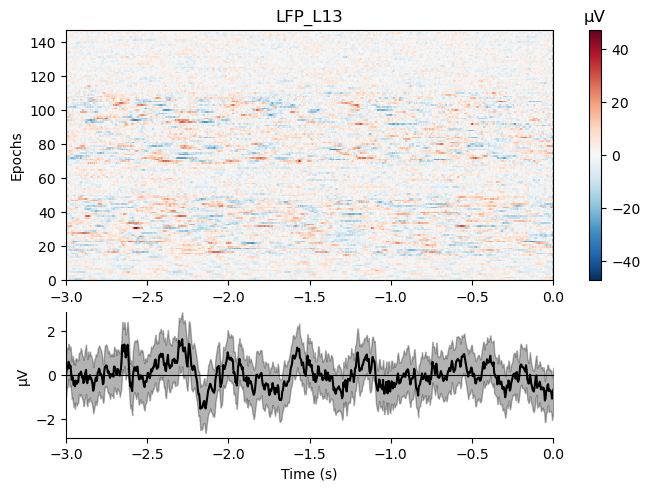

[<Figure size 640x480 with 3 Axes>]

In [ ]:
epochs['mod_start'].plot_image(picks=[1])

In [ ]:
# bad_epoch = np.argmin(epochs['mod_start'].get_data()[76, 5,:]) 
# # epochs[76, 5, 54] = np.mean(epochs['mod_start'].get_data()[76, 5,:])
# # epochs['mod_start'].get_data()[76, 5, 54]
# epochs.drop(bad_epoch)

In [ ]:
# # def remove_outliers(epochs, threshold=3):

# # Compute the mean and standard deviation across epochs
# data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
# threshold=3

# # Reshape to (n_epochs, n_channels * n_times)
# reshaped_data = data.reshape(data.shape[0], -1)

# # Calculate z-scores
# z_scores = np.abs((reshaped_data - np.mean(reshaped_data, axis=0)) / np.std(reshaped_data, axis=0))

# # Identify outlier epochs
# outlier_epochs = np.where(z_scores > threshold)

# # Remove outlier epochs
# clean_epochs = epochs.copy().drop(outlier_epochs[0])

# # cleaned_epochs = remove_outliers(epochs)

# Statistical Analysis

## T-Test on Band Power Features

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Initialize results storage
t_stats = {}
p_values = {}

# Loop through each frequency band
for band in band_power_mod_start.keys():
    # Average across epochs (axis=0) and channels (axis=1)
    mean_mod = np.mean(band_power_mod_start[band], axis=0)
    mean_norm = np.mean(band_power_normal_walking[band], axis=0)
    
    # Perform a t-test
    t_stat, p_value = stats.ttest_ind(mean_mod, mean_norm)
    
    # Store the results
    t_stats[band] = t_stat
    p_values[band] = p_value

# Display results
for band in t_stats.keys():
    print(f'Band {band}: T-statistic: {t_stats[band]:.4f}, P-value: {p_values[band]:.4f}')

## T-Test on PSD Features

In [ ]:
# Initialize results storage
t_stats_psd = {}
p_values_psd = {}

# Loop through each frequency band
for band in psd_features_mod_start.keys():
    # Average across epochs (axis=0) and channels (axis=1) for each frequency
    mean_psd_mod = np.mean(psd_features_mod_start[band], axis=(0, 1))  # Mean across epochs and channels
    mean_psd_norm = np.mean(psd_features_normal_walking[band], axis=(0, 1))  # Mean across epochs and channels
    
    # Perform a t-test
    t_stat_psd, p_value_psd = stats.ttest_ind(mean_psd_mod, mean_psd_norm)
    
    # Store the results
    t_stats_psd[band] = t_stat_psd
    p_values_psd[band] = p_value_psd

# Display results
for band in t_stats_psd.keys():
    print(f'Band: {band}, T-statistic: {t_stats_psd[band]:.4f}, P-value: {p_values_psd[band]:.4f}')

# Baseline Model (LogisticRegression)

In [ ]:
print(epochs.get_data().shape)
print(epochs['mod_start'].get_data().shape)
print(epochs['normal_walking'].get_data().shape)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Assuming epochs are in the shape (n_epochs, n_channels, n_frequencies)
# Convert your epochs data into a suitable format for classification
# For this example, we'll use the 'mod_start' and 'normal_walking' classes

# Load your data
X_mod_start = epochs['mod_start'].get_data(copy=True)  # Shape: (147, 6, 501)
X_normal_walking = epochs['normal_walking'].get_data(copy=True)  # Shape: (610, 6, 501)

# Combine the data and create labels
X = np.concatenate((X_mod_start, X_normal_walking), axis=0)  # Shape: (757, 6, 501)
y = np.array([0] * X_mod_start.shape[0] + [1] * X_normal_walking.shape[0])  # 0 for mod_start, 1 for normal_walking

# Flatten the data across channels and frequencies for classification
n_epochs = X.shape[0]
X_flat = X.reshape(n_epochs, -1)  # Shape: (757, 6 * 501)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5)

# Initialize model
model = LogisticRegression(max_iter=1000)

# Store the results
scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_flat, y):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evaluate
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    scores.append(score)

# Average accuracy across folds
mean_score = np.mean(scores)
print(f'Mean accuracy: {mean_score:.2f}')

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression  # Example model; you can replace it with your model
from sklearn.preprocessing import StandardScaler

# Assuming X is your features and y are the labels
X = epochs.get_data(copy=True).reshape(epochs.get_data(copy=True).shape[0], -1)  # Reshape to (n_epochs, n_channels * n_features)
y = np.array([0] * epochs['mod_start'].get_data(copy=True).shape[0] + [1] * epochs['normal_walking'].get_data(copy=True).shape[0])  # Example labels

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5)  # You can choose any number of splits
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

# Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Optional: Scale your features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train your model
    model = LogisticRegression()  # Example model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
    metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

# Calculate mean and standard deviation for metrics
for key in metrics:
    if key != 'confusion_matrices':
        print(f"{key.capitalize()} - Mean: {np.mean(metrics[key]):.2f}, Std: {np.std(metrics[key]):.2f}")
    else:
        # Print confusion matrices
        for i, cm in enumerate(metrics['confusion_matrices']):
            print(f"Confusion Matrix for fold {i + 1}:\n{cm}\n")

In [ ]:
X.shape, y.shape

In [ ]:
epochs['mod_start'].get_data().shape, epochs['normal_walking'].get_data().shape

## 2. Temporal models - LSTM Model

In [ ]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    print("Using GPU")
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Using CPU.")

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data
# Assuming epochs is already defined and contains your data.
X_mod = epochs['mod_start'].get_data()  # Shape: (147, 6, 501)
X_norm = epochs['normal_walking'].get_data()  # Shape: (610, 6, 501)

# Stack your data
X = np.concatenate([X_mod, X_norm], axis=0)  # Shape: (757, 6, 501)
y = np.concatenate([np.zeros(X_mod.shape[0]), np.ones(X_norm.shape[0])])  # Labels: 0 for mod_start, 1 for normal_walking

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Step 3: Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

all_metrics = []

# Step 4: Initialize a list to store history
histories = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape the data for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    model = create_model((X_train.shape[1], X_train.shape[2]))
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Step 5: Train the Model and save history
    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        # callbacks=[early_stopping],
                        )
    
    histories.append(history.history)  # Store history for plotting
    
    # Step 6: Evaluate the Model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    all_metrics.append((accuracy, precision, recall, f1))

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['mod_start', 'normal_walking'], yticklabels=['mod_start', 'normal_walking'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Step 8: Plotting Learning Progress
# Check minimum length of history entries
min_length = min(len(history['loss']) for history in histories)

# Truncate histories to the minimum length
avg_train_loss = np.mean([history['loss'][:min_length] for history in histories], axis=0)
avg_val_loss = np.mean([history['val_loss'][:min_length] for history in histories], axis=0)
avg_train_accuracy = np.mean([history['accuracy'][:min_length] for history in histories], axis=0)
avg_val_accuracy = np.mean([history['val_accuracy'][:min_length] for history in histories], axis=0)

# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Train Loss', color='blue')
plt.plot(avg_val_loss, label='Validation Loss', color='orange')
plt.title('Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Train Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Accuracy Progression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Filtering the data

In [ ]:
# raw psd
raw_spectrum = raw_data_clean.compute_psd(method='welch', fmin=1, fmax=50, n_fft=2048)

psd_arr = raw_spectrum.get_data()
psd_freqs = raw_spectrum.freqs
print(raw_data_clean.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

raw_spectrum.plot()

In [ ]:
raw_spectrum.get_data().shape, raw_data_clean.get_data().shape

In [ ]:
# epochs psd: Train set
train_epoch_spectrum = train_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = train_epoch_spectrum.get_data()
psd_freqs = train_epoch_spectrum.freqs

print(train_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

train_epoch_spectrum.plot(average=False)

In [ ]:
train_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
train_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
# epochs psd: Test set
test_epoch_spectrum = test_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = test_epoch_spectrum.get_data()
psd_freqs = test_epoch_spectrum.freqs

print(test_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

test_epoch_spectrum.plot(average=False)

In [ ]:
test_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
test_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
train_all_epochs_combined.get_data().shape, train_epoch_spectrum.get_data().shape



# train_all_epochs_combined.events[:, -1].shape, test_all_epochs_combined.events[:, -1].shape

## Logistic Regression based on PSD

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Step 1: Train-test split
X_train = train_epoch_spectrum.get_data()
X_test = test_epoch_spectrum.get_data()

y_train = train_all_epochs_combined.events[:, -1]
y_test = test_all_epochs_combined.events[:, -1]

print(f'X_train shape: {X_train.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_train shape: {y_train.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_train == -1)} normal walking and {sum(y_train == 1)} event-related gait modulation')

print(f'X_test shape: {X_test.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_test shape: {y_test.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_test == -1)} normal walking and {sum(y_test == 1)} event-related gait modulation')

# Step 2: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Output the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# ICA raw
## CODE GOES HERE
ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
ica_95PCA.fit(inst=lfp_raw)
# ica_95PCA.plot_sources(inst=lfp_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# raw_ica_excluded = ica.apply(inst=lfp_raw.copy())
# raw_ica = ica.apply(inst=lfp_raw.copy())

# raw_ica_excluded.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')
# raw_ica.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')

In [ ]:
# # ICA rpochs
# ## CODE GOES HERE
# ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
# ica_95PCA.fit(inst=epochs_raw)
# ica_95PCA.plot_sources(inst=epochs_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# # Compute variance explained by PCA components
# explained_variance = ica.pca_explained_variance_ / np.sum(ica.pca_explained_variance_)

# print(f"Variance explained by PCA components: {explained_variance}")
# print(f"Variance explained by first 4 PCA components: {np.sum(explained_variance[:4]) * 100:.2f}%")

In [ ]:
# ica = mne.preprocessing.ICA(random_state=0)
# ica.fit(raw_sensors)

# # Remove the first ICA component (the random noise) from the data
# raw_cleaned = ica.apply(inst=raw_sensors.copy(), exclude=[1,2])
# raw_cleaned.plot(scalings='auto', title='clraned sensor signals (without noise)')

In [ ]:
epochs_raw["mod_start"].plot_image(combine="mean");

In [ ]:
mne.viz.plot_epochs_image(
    epochs_raw['mod_start'],
    picks=[0, 1, 2, 3, 4, 5],
    sigma=0.5,
    # combine="mean",
    # evoked=True
)

# Evoked

evoked_0 = epochs_raw['trial_start'].average()
evoked_4 = epochs_raw['mod_start'].average()

## Global Field Power (GFP)

The GFP is the population standard deviation of the signal across channels.

In [ ]:
fig0 = evoked_0.plot(gfp=True);
fig1 = evoked_1.plot(gfp=True);

In [ ]:
evoked_0.plot(gfp="only");
evoked_1.plot(gfp="only");

In [ ]:
gfp = evoked_0.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_0.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_0.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

In [ ]:
gfp = evoked_1.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_1.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_1.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

# # Time-frequency analysis

In [ ]:
freqs = np.arange(2, 50, 2) # Frequencies from 2 to 50 Hz
n_cycles = freqs / 2 # Number of cycles in Morlet wavelet


In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['mod_start'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['min_vel'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

# CSD

In [ ]:
csd_fft = mne.time_frequency.csd_fourier(train_all_epochs_combined, fmin=1, fmax=50)
csd_mt = mne.time_frequency.csd_multitaper(train_all_epochs_combined, fmin=1, fmax=50, adaptive=True)
frequencies = np.arange(1,51, 1)
csd_wav = mne.time_frequency.csd_morlet(train_all_epochs_combined, frequencies, decim=1)

In [ ]:
plot_dict = {
    "Short-time Fourier transform": csd_fft,
    "Adaptive multitapers": csd_mt,
    "Morlet wavelet transform": csd_wav,
}
for title, csd in plot_dict.items():
    (fig,) = csd.mean().plot()
    fig.suptitle(title)